# Cluster genes

For this tutorial, we will be analyzing the a dataset of Peripheral Blood Mononuclear Cells (PBMC) freely available from 10X Genomics. There are 2,700 single cells that were sequenced on the Illumina NextSeq 500. The raw data can be found here https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz. Further more we use `scanpy` to analyse the data which is a sparse matrix

The Scanpy object is a data structure used in the Scanpy package for single-cell RNA sequencing (scRNA-seq) analysis in Python. It is designed to store and manage scRNA-seq data along with associated metadata, results of quality control and pre-processing steps, and results of downstream analyses such as cell clustering, differential gene expression analysis, and data visualization.

The Scanpy object is built on top of the AnnData object, which is a generic container for annotated data in Python. It typically contains the following components:

- `.X`: a matrix or sparse matrix of gene expression data, where rows correspond to cells and columns correspond to - genes. This matrix is used for downstream analyses.
- `.obs`: a DataFrame containing metadata for each cell, such as cell type, sample ID, and experimental condition.
- `.var`: a DataFrame containing metadata for each gene, such as gene name, gene ID, and gene biotype.
- `.obsm`: a dictionary of additional per-cell annotations, such as cell embeddings obtained through dimensionality reduction methods like principal component analysis (PCA) or t-distributed stochastic neighbor embedding (t-SNE).-
- `.varm`: a dictionary of additional per-gene annotations.
- `.uns`: a dictionary of unstructured annotations, which can be used to store arbitrary data or metadata.
- `.obs_names`: a vector of cell names or IDs.
- `.var_names`: a vector of gene names or IDs.

The Scanpy object provides various methods and functions for quality control, data normalization, dimensionality reduction, clustering, differential gene expression analysis, and visualization of scRNA-seq data. The object can be easily manipulated using standard Python data manipulation techniques and integrated with other Python packages for scRNA-seq analysis


The perform the clustering we perform several steps
- Loading the data
- Filter out cells and genes with low expression levels
- Filter on QC metrics
- Normalizing using log
- Scaling
- Dimension reduction
- Clustering (based on the components)
- Visualizing the clusters


source: https://satijalab.org/seurat/archive/v3.1/pbmc3k_tutorial.html

https://scanpy-tutorials.readthedocs.io/en/latest/index.html#

In [1]:
import pandas as pd
import numpy as np
import yaml
import scanpy as sc

## Load the PBMC dataset

The code loads scRNA-seq data from a directory in the 10x Genomics' filtered gene-barcode matrix (mtx) format using Scanpy's read_10x_mtx function. The loaded data is stored in the pbmc_data object.

The AnnData object is then initialized using the pbmc_data object. This object is used to store and manage scRNA-seq data along with associated metadata, results of quality control and pre-processing steps, and results of downstream analyses such as cell clustering, differential gene expression analysis, and data visualization.

The initialized AnnData object is assigned to the variable pbmc, and it contains the raw (non-normalized) scRNA-seq data as well as the metadata associated with the data. The obs attribute contains cell metadata, the var attribute contains gene metadata, the obsm attribute contains additional per-cell annotations, and the varm attribute contains additional per-gene annotations. The obs_names and var_names attributes are assigned the cell and gene names or IDs from the pbmc_data object.

In [2]:
pbmc_data = sc.read_10x_mtx("data/filtered_gene_bc_matrices/hg19/")

# Initialize the AnnData object with the raw (non-normalized data).
pbmc = sc.AnnData(pbmc_data.X, obs=pbmc_data.obs, var=pbmc_data.var, obsm=pbmc_data.obsm, varm=pbmc_data.varm)
pbmc.obs_names = pbmc_data.obs_names
pbmc.var_names = pbmc_data.var_names
pbmc

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Filter out cells and genes with low expression levels

Filtering steps are important for quality control and to remove low-quality or lowly expressed cells and genes from downstream analysis. It can improve the accuracy of cell clustering, differential gene expression analysis, and other analyses that depend on gene expression values

The `sc.pp.filter_cells` function filters out cells that have expressed fewer than a certain number of genes specified by the min_genes parameter. In this case, any cell with fewer than 200 expressed genes will be removed from the pbmc object.

The `sc.pp.filter_genes` function filters out genes that are expressed in fewer than a certain number of cells specified by the min_cells parameter. In this case, any gene that is expressed in fewer than 3 cells will be removed from the pbmc object.

In [3]:
sc.pp.filter_cells(pbmc, min_genes=200)
sc.pp.filter_genes(pbmc, min_cells=3)

## Inspect the structure of the data

Let us inspect the structure of the data. As mentioned 
- `.obs` is a DataFrame containing metadata for each cell, such as cell type, sample ID, and experimental condition.
- `.var`is a DataFrame containing metadata for each gene, such as gene name, gene ID, and gene biotype.

In our case only the names of the genes, the name of the sample, number of genes, gene ids and number of cells are available

In [4]:
#pbmc?

In [5]:
pbmc.obs_names

Index(['AAACATACAACCAC-1', 'AAACATTGAGCTAC-1', 'AAACATTGATCAGC-1',
       'AAACCGTGCTTCCG-1', 'AAACCGTGTATGCG-1', 'AAACGCACTGGTAC-1',
       'AAACGCTGACCAGT-1', 'AAACGCTGGTTCTT-1', 'AAACGCTGTAGCCA-1',
       'AAACGCTGTTTCTG-1',
       ...
       'TTTCAGTGTCACGA-1', 'TTTCAGTGTCTATC-1', 'TTTCAGTGTGCAGT-1',
       'TTTCCAGAGGTGAG-1', 'TTTCGAACACCTGA-1', 'TTTCGAACTCTCAT-1',
       'TTTCTACTGAGGCA-1', 'TTTCTACTTCCTCG-1', 'TTTGCATGAGAGGC-1',
       'TTTGCATGCCTCAC-1'],
      dtype='object', length=2700)

In [6]:
pbmc.var_names

Index(['AL627309.1', 'AP006222.2', 'RP11-206L10.2', 'RP11-206L10.9',
       'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'RP11-54O7.17', 'HES4',
       ...
       'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'AC145212.1',
       'AL592183.1', 'AL354822.1', 'PNRC2-1', 'SRSF10-1'],
      dtype='object', length=13714)

## .obs
`.obs` stores the cell metadata. There are 2,700 single cells that were sequenced on the Illumina NextSeq 500. The Read10X function reads in the output of the cellranger pipeline from 10X, returning a unique molecular identified (UMI) count matrix. The values in this matrix represent the number of molecules for each feature (i.e. gene; row) that are detected in each cell (column).

In [7]:
pbmc.obs.head() # n_genes = nFeature_RNA (to)

,n_genes
AAACATACAACCAC-1,781
AAACATTGAGCTAC-1,1352
AAACATTGATCAGC-1,1131
AAACCGTGCTTCCG-1,960
AAACCGTGTATGCG-1,522


In [8]:
pbmc.obs.shape

(2700, 1)

## .var

`.var` contains the metadata for the detected genes. There are 13714 genes across 2700 samples

In [9]:
pbmc.var.head()

,gene_ids,n_cells
AL627309.1,ENSG00000237683,9
AP006222.2,ENSG00000228463,3
RP11-206L10.2,ENSG00000228327,5
RP11-206L10.9,ENSG00000237491,3
LINC00115,ENSG00000225880,18


In [10]:
pbmc.var.shape

(13714, 2)

## QC metrics

QC metrics are quality control metrics used to assess the quality and validity of data generated from single-cell sequencing experiments. These metrics are used to filter out cells and genes that are of low quality or are considered outliers. The following are some commonly used QC metrics:
- Number of genes detected per cell: This metric represents the total number of genes detected in a single cell and is used to filter out cells that have a low number of detected genes, which may be an indication of poor RNA quality or low sequencing depth
- Mitochondrial gene content: Mitochondrial genes are highly expressed in cells with high levels of mitochondrial activity. The percentage of mitochondrial genes detected in a cell is used as a proxy for the overall mitochondrial activity of the cell. High levels of mitochondrial gene expression may be indicative of poor cell quality or cell stress

In [11]:
pbmc.var['mt'] = pbmc.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(pbmc, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [12]:
pbmc.var

,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL627309.1,ENSG00000237683,9,False,9,0.003333,99.666667,9.0
AP006222.2,ENSG00000228463,3,False,3,0.001111,99.888889,3.0
RP11-206L10.2,ENSG00000228327,5,False,5,0.001852,99.814815,5.0
RP11-206L10.9,ENSG00000237491,3,False,3,0.001111,99.888889,3.0
LINC00115,ENSG00000225880,18,False,18,0.006667,99.333333,18.0
...,...,...,...,...,...,...,...
AC145212.1,ENSG00000215750,16,False,16,0.006667,99.407407,18.0
AL592183.1,ENSG00000220023,323,False,323,0.134815,88.037037,364.0
AL354822.1,ENSG00000215615,8,False,8,0.002963,99.703704,8.0
PNRC2-1,ENSG00000215700,110,False,110,0.042963,95.925926,116.0


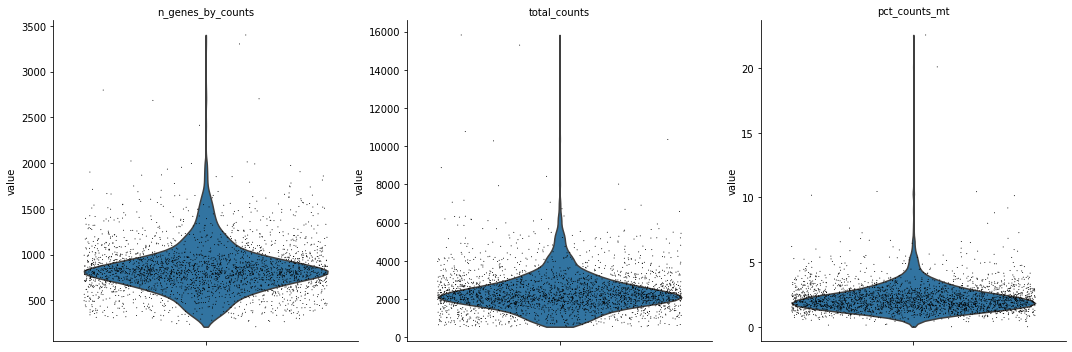

In [13]:
sc.pl.violin(pbmc, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

## plot relations
The first plot shows the relationship between the total counts (total number of RNA molecules detected in each cell) and the percentage of counts coming from mitochondrial genes for each cell. This plot can help identify cells with high mitochondrial content, which can indicate poor quality cells or cells that have undergone stress.

The second plot shows the relationship between the total counts and the number of genes detected in each cell. This plot can help identify cells with low RNA content

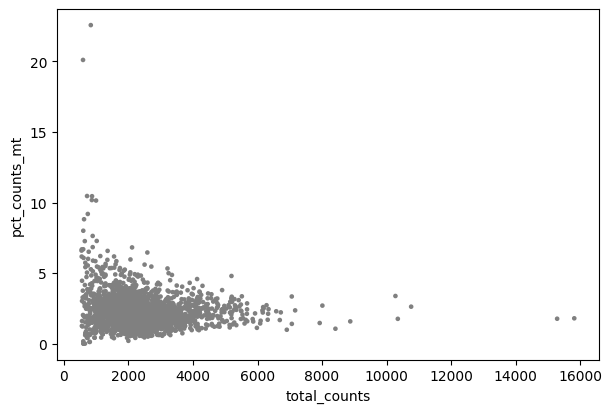

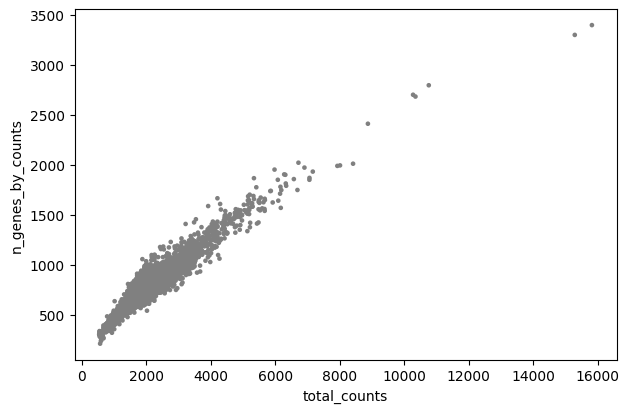

In [14]:
sc.pl.scatter(pbmc, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(pbmc, x='total_counts', y='n_genes_by_counts')

- We filter cells that have unique feature counts over 2,500 or less than 200
- We filter cells that have >5% mitochondrial counts

In [15]:
pbmc = pbmc[pbmc.obs.n_genes_by_counts < 2500, :]
pbmc = pbmc[pbmc.obs.n_genes_by_counts > 200, :]
pbmc = pbmc[pbmc.obs.pct_counts_mt < 5, :]

## Normalizing the data

After removing unwanted cells from the dataset, the next step is to normalize the data. By default, we employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. 



In [16]:
#Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.normalize_total(pbmc, target_sum=1e4, copy = True)

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [17]:
sc.pp.log1p(pbmc, base = 1000, copy = True)

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

to remove unwanted sources of variation from a single-cell dataset, we could ‘regress out’ heterogeneity associated with (for example) cell cycle stage, or mitochondrial contaminationTo perform regression on a set of variables during scaling in Scanpy, you can use the `pp.regress_out()` function

In [18]:
sc.pp.regress_out(pbmc, ['total_counts', 'pct_counts_mt'])

Next, we apply a linear transformation (‘scaling’) that is a standard pre-processing step prior to dimensional reduction techniques like PCA

In [19]:
# Scale the data
sc.pp.scale(pbmc, copy = True)

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'

## PCA

To run principal component analysis (PCA) in Scanpy you can use the `sc.tl.pca() ` function. The resulting principal components are stored in the X_pca attribute of the adata object. Finally, the `sc.pl.pca_variance_ratio()` function creates a plot showing the explained variance by each principal components

The `sc.tl.pca` function computes the PCA on the variable features of the pbmc_filtered object, which are the genes that have a high degree of variation across the cells. PCA is a dimensionality reduction technique that identifies linear combinations of variables that explain the maximum amount of variance in the data. In the context of scRNA-seq data, PCA can be used to reduce the dimensionality of the data and identify the most informative features that distinguish between cell types or states.

The `sc.pl.pca_variance_ratio` function creates a plot that shows the percentage of variance explained by each principal component. This allows us to visualize how much of the variation in the data is captured by each principal component and determine how many principal components are necessary to explain the majority of the variance

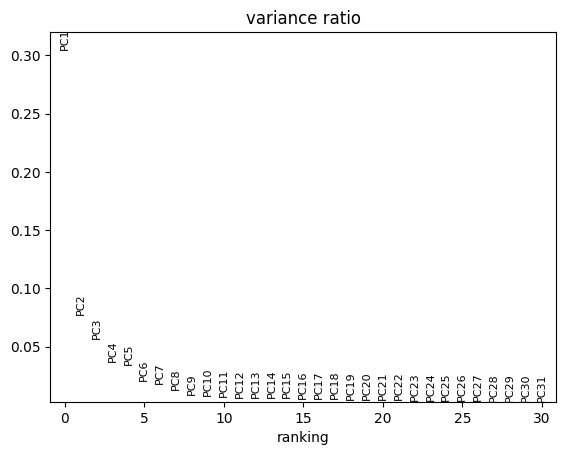

In [20]:
# Run PCA on the variable features
sc.tl.pca(pbmc)

# Create a plot of the explained variance by each principal component
sc.pl.pca_variance_ratio(pbmc)

In [21]:
pbmc

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

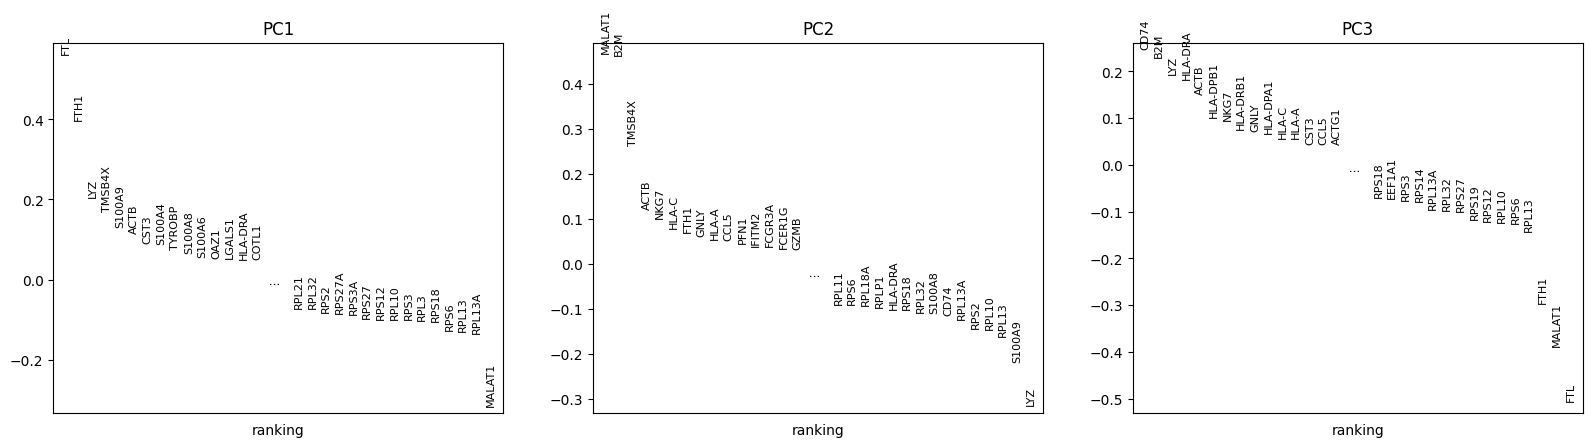

In [22]:
sc.pl.pca_loadings(pbmc, show=True)

In [23]:
pbmc

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

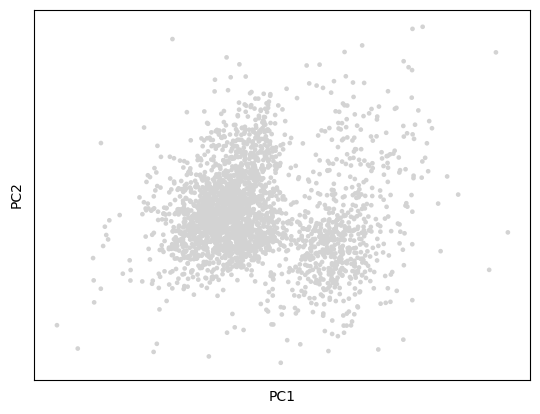

In [24]:
sc.pl.pca(pbmc)

## Clustering

Next we will perform a clustering analysis on the filtered scRNA-seq data using the Louvain algorithm, which is a popular and effective method for identifying cell clusters in scRNA-seq data. 

The `sc.pp.neighbors` function computes the k-nearest neighbor graph of cells in the pbmc_filtered object. The `n_neighbors` parameter specifies the number of nearest neighbors to use for constructing the graph, and `n_pcs` specifies the number of principal components to use for computing distances between cells. The neighborhood graph is a way to represent the high-dimensional scRNA-seq data in a lower-dimensional space, which can be used for various downstream analyses, including cell clustering and visualization.

The `sc.tl.leiden` function performs clustering on the neighborhood graph using the Louvain algorithm. The `resolution` parameter determines the granularity of the clustering, with higher values leading to more clusters. The Louvain algorithm iteratively optimizes the modularity score of the graph by merging or splitting clusters of cells based on their connectivity. This results in the assignment of each cell to a specific cluster, which can be used for downstream analyses, such as differential gene expression analysis or cell type identification

In [25]:
# Compute neighbors and perform Louvain clustering
sc.pp.neighbors(pbmc, n_neighbors=10, n_pcs=10)
sc.tl.leiden(pbmc, resolution = 0.5)

In [26]:
pbmc

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca', 'neighbors', 'leiden'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

##  Visualize the clusters in the UMAP plot
Next we create a UMAP plot that visualizes the clustering results of the filtered scRNA-seq data. This is an important step in scRNA-seq analysis, as it allows us to gain insights into the underlying cell populations and identify potential markers that can be used for downstream analyses. The `sc.tl.umap` function performs dimensionality reduction using UMAP on the filtered scRNA-seq data in the pbmc_filtered object. The n_components parameter specifies the number of dimensions in the UMAP space to be created, which is set to 2 in this case. UMAP is a non-linear dimensionality reduction method that is commonly used for visualization of high-dimensional scRNA-seq data.

The `sc.pl.umap` function plots the UMAP coordinates of each cell in the pbmc_filtered object, with the color of each point indicating the cluster identity obtained from the Louvain algorithm. This allows us to visually inspect the clustering results and identify potential subpopulations of cells that may represent different cell types or states.

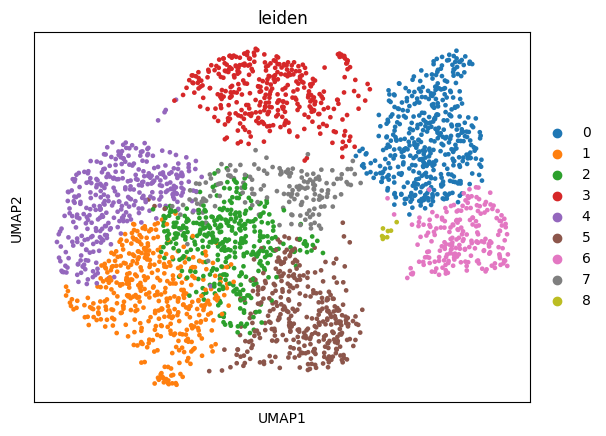

In [27]:
sc.tl.umap(pbmc, n_components=2)
sc.pl.umap(pbmc, color='leiden')